
=== BLACKJACK MENU ===
1. Play against the dealer (manual)
2. Train *basic* Q-agent
3. Evaluate *basic* agent
4. Compare to basic-strategy chart
5. Train *Hi-Lo* counting agent
6. Evaluate *Hi-Lo* agent
7. EXIT


100%|██████████| 5000000/5000000 [03:34<00:00, 23316.96it/s]
C:\Users\mixla\AppData\Local\Temp\ipykernel_8832\1520868277.py:253: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


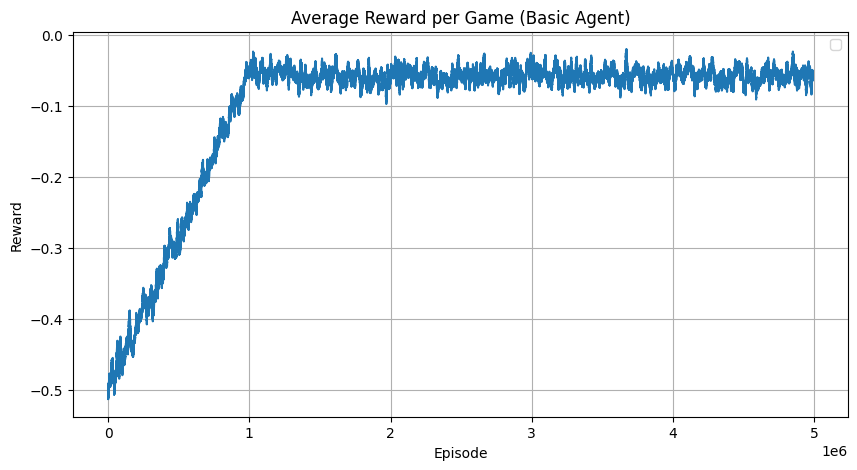


=== BLACKJACK MENU ===
1. Play against the dealer (manual)
2. Train *basic* Q-agent
3. Evaluate *basic* agent
4. Compare to basic-strategy chart
5. Train *Hi-Lo* counting agent
6. Evaluate *Hi-Lo* agent
7. EXIT


100%|██████████| 100000/100000 [00:04<00:00, 22166.63it/s]


Total profit: $-2531.00
Average profit per game: $-0.03
Average bet size: $1.00
Double-down rate: 1.74% of games
Double-down win rate: 60.48%
Win 43.18%  Draw 9.18%  Lose 47.64%

=== BLACKJACK MENU ===
1. Play against the dealer (manual)
2. Train *basic* Q-agent
3. Evaluate *basic* agent
4. Compare to basic-strategy chart
5. Train *Hi-Lo* counting agent
6. Evaluate *Hi-Lo* agent
7. EXIT
Mismatch: (6, 5, 0, 0) → Agent: STICK vs Strategy: HIT
Mismatch: (12, 5, 0, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (12, 6, 0, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (13, 2, 0, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (13, 3, 0, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (13, 4, 0, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (18, 2, 1, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (18, 3, 1, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (18, 4, 1, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (18, 5, 1, 0) → Agent: HIT vs Strategy: STICK
Mismatch: (18, 6, 1, 0) → Agent: HIT vs Strategy: S

100%|██████████| 5000000/5000000 [02:18<00:00, 36007.82it/s]
C:\Users\mixla\AppData\Local\Temp\ipykernel_8832\1520868277.py:689: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


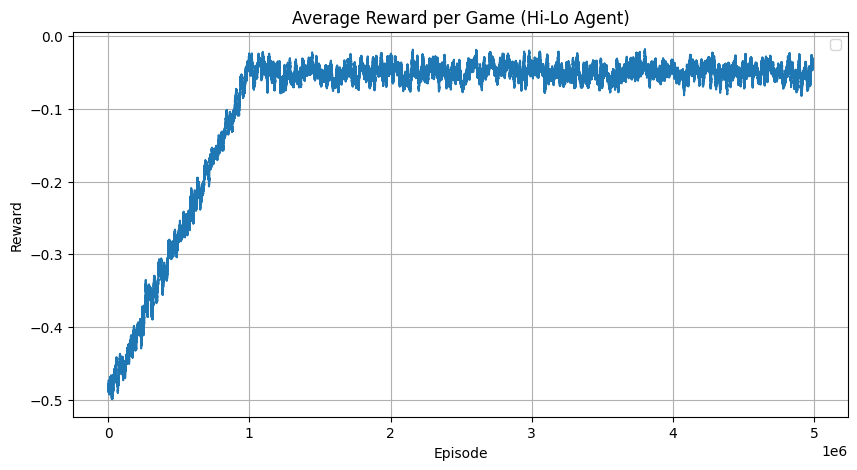


=== BLACKJACK MENU ===
1. Play against the dealer (manual)
2. Train *basic* Q-agent
3. Evaluate *basic* agent
4. Compare to basic-strategy chart
5. Train *Hi-Lo* counting agent
6. Evaluate *Hi-Lo* agent
7. EXIT
Q-values for (11, 6, 0, 1, 2): [ 0.41680113 -0.13749561  0.87595555]


100%|██████████| 100000/100000 [00:02<00:00, 43678.33it/s]


Total profit: $-1897.50
Average profit per game: $-0.02
Average bet size: $1.00
Double-down rate: 2.38% of games
Double-down win rate: 62.37%
Hi-Lo 0: Double-down rate=0.05%, Win rate=56.60%
Hi-Lo 1: Double-down rate=1.42%, Win rate=64.21%
Hi-Lo 2: Double-down rate=0.91%, Win rate=59.82%
Win 43.36%  Draw 9.16%  Lose 47.48%

=== BLACKJACK MENU ===
1. Play against the dealer (manual)
2. Train *basic* Q-agent
3. Evaluate *basic* agent
4. Compare to basic-strategy chart
5. Train *Hi-Lo* counting agent
6. Evaluate *Hi-Lo* agent
7. EXIT
Goodbye!


In [5]:

# ========= Reinforcement Learning and Dynamic Optimization ======== #
# -------------Card Counting Black Jack: Phase 2-------------------- #
#
# Michalis Lamprakis  2020030077
# Dimitris Ilia       2020030200


# ==================================================================== #
# TASK 1: Implement a more 'realistic' Blackjack environment with a Q-learning agent.
# ==================================================================== #

import numpy as np
from collections import defaultdict
import random
import tqdm                             # This is for the progress bar
import matplotlib.pyplot as plt
import numpy as np

HIT  = 0
STICK = 1
DOUBLE_DOWN = 2
A = [HIT, STICK, DOUBLE_DOWN]

# BlackJack Environment.
# Methods starts with _ naming convention for private methods (called only inside the environment).

class BlackjackEnv:

    # Constructor initializes the environment.
    # Called with the creation of the environment.
    def __init__(self, max_bet=10):
      self.max_bet = max_bet
      self.current_bet = 1
      self.reset()

    # Deck creation.
    # Each card is a tuple (rank, suit) e.g (4,hearts) , (A,spades)
    def _init_deck(self):
      suits = ['hearts', 'spades', 'diamonds', 'clubs']
      ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
      self.deck = []
      for suit in suits:
          for rank in ranks:
              self.deck.append((rank, suit))


    # Card value function
    # Calculate the value of each card.
    def _card_value(self,card):
        rank = card[0] # Take the rank of each card from the tuple
        if rank in ['J', 'Q', 'K']:
            return 10
        elif rank == 'A':
            return 11  # Initially count Ace as 11, change it later if needed
        else:
            return int(rank) # Else, each card counts as the number of the rank (it is a string so we convert it into int)

    # Calculate hand value
    def _hand_value(self,hand):
        value = 0 # Total hand value
        num_of_aces = 0 # Keeps track the num of aces

        # For each card in hand sum the value and if there is an ace increase num_aces
        for card in hand:
            value += self._card_value(card)
            if card[0] == 'A':
                num_of_aces += 1
        # While the total hand value is greater than 21 AND there is an ace in the game subtract 10 from the sum
        # (this means we count the ace from 11 to 1) and deacrease the number of aces, repeat until sum is less than 21 or the num of aces is 0.
        while (value > 21) and (num_of_aces > 0):
            value -= 10  # convert an Ace from 11 to 1
            num_of_aces -= 1

        usable_ace = (num_of_aces > 0) # If num of aces is > 0 there is a usable ace so return it
        return value, usable_ace


    # Resets the game
    def reset(self, initial_bet=1):
        self._init_deck()
        random.shuffle(self.deck) # Shuffle the deck

        #Initialize bet
        self.current_bet = min(initial_bet, self.max_bet)

        # Make user's and dealer hand.
        # pop() removes the top card from the shuffled game_deck.
        self.player = [self.deck.pop(), self.deck.pop()]
        self.dealer = [self.deck.pop(), self.deck.pop()]

        self.can_double = True  # Track double-down eligibility

        return self._get_obs(), {} # Returns the initial observation (state).


    # Obs stands for observation
    # Returns the state of the game as a tuple of {players hand value, dealer's first visible card, wheather player have a usable ace or not, truncated, info}
    # We use the standard open AI gym format even thow we dont use all the elements from the tuple
    def _get_obs(self):
        value, usable_ace = self._hand_value(self.player)
        return (value,
                self._card_value(self.dealer[0]),   # 2..11
                int(usable_ace),                    # 0 or 1
                int(self.can_double) )              # Add double eligibility to state

    # Handles the game logic for each action.
    # returns a tuple {new state obervation, reward (1,0,-1), is the game terminating (boolean) }
    def step(self, action):

        terminated = False # Condition for game termination

        reward = 0         # Reward

        # Action Double Down
        if action == DOUBLE_DOWN and self.can_double:
          # Double-down logic
          self.current_bet *= 2
          self.player.append(self.deck.pop())
          self.can_double = False  # Can't double after this
          terminated = True  # Mandatory termination after double

        # Player hits
        if action == HIT:
            self.player.append(self.deck.pop())
            self.can_double = False  # Lose double option after hit

        player_value, _ = self._hand_value(self.player)

        # If value is > 21 player loses and game ends else game continues.
        if player_value > 21:
            terminated = True

        # Dealer's turn if STICK or DOUBLE
        # If dealer's hand value is 16 or less the dealer MUST draw another card else the dealer MUST stay.
        if action in [STICK, DOUBLE_DOWN] or terminated:
            dealer_value, _ = self._hand_value(self.dealer)
            while dealer_value < 17:
                self.dealer.append(self.deck.pop())
                dealer_value, _ = self._hand_value(self.dealer)

            reward = self._calculate_reward(player_value, dealer_value)
            terminated = True

        return self._get_obs(), reward, terminated, False, {}

    def _calculate_reward(self, player, dealer):
          if player > 21:
              return -self.current_bet
          if dealer > 21:
              return self.current_bet
          if player == dealer:
              return 0
          # Natural blackjack check (blackjack at start)
          if len(self.player) == 2 and player == 21:
              return self.current_bet * 1.5

          if player > dealer:
              return self.current_bet
          else:
              return -self.current_bet
# Q Table creation
# defaultdict: Automatic state creation when the agent encounters a new state. The state tuple becomes a dictionary key and the default Q values are [0.0, 0.0].
# We expect 360x2 table because:
# Player's hand total: 4-21 (18 possible values) (e.g A and 2 is not 3 but 13 that's why)
# Dealer's visible card: 2-11 (10 possible values)
# Usable ace: Yes/No (2 possible values)
# Can double: Yes/No (2 possible values)
# 18 × 10 × 2 x 2 = 720 possible state combinations
# And 3 possible actions HIT(0), STICK(1), DOUBLE(2)
Q = defaultdict(lambda: np.zeros(3))  # Now has HIT(0), STICK(1), DOUBLE(2)


# alpha = 0.05                                    # Learning rate (how aggressively we update values)   # I can use standard alpha and 2 mil episodes for faster results.

alpha_start = 0.1   # Initial learning rate
alpha_end = 0.01    # Minimum learning rate
alpha_decay = 2e5   # Decay rate for learning rate

gamma = 1.0                                     # Discount factor (1.0 = no discount for future rewards)
e_start = 1.0                                   # Initial exploration rate
e_end = 0.05                                    # Minimum exploration rate
e_decay = 1e6                                   # Rate of exploration decay # Decay over 1,000,000 episodes
episodes = 5_000_000                            # Number of episodes



def policy(state, eps):
    player_total, dealer_card, usable_ace, can_double = state
    valid_actions = [HIT, STICK]

    if can_double:
        valid_actions.append(DOUBLE_DOWN)

    if random.random() < eps:
        return random.choice(valid_actions)

    # Prevents illegal moves: Agent can't choose DOUBLE_DOWN when unavailable
    masked_q = []
    for a in A:  # A = [HIT, STICK, DOUBLE_DOWN]
        if a in valid_actions:
            masked_q.append(Q[state][a])
        else:
            masked_q.append(-np.inf)  # If double down is unavailable set it to -inf.

    action = np.argmax(masked_q)

    return action


def train():
    env = BlackjackEnv()
    eps = e_start

    reward_log = []

    for ep in tqdm.tqdm(range(episodes)):
        s, _ = env.reset()
        terminated = False

        # Calculate decaying learning rate for this episode
        alpha = max(alpha_end, alpha_start - (alpha_start - alpha_end) * ep / alpha_decay)

        episode_reward = 0
        while not terminated:
            a = policy(s, eps)
            next_state, reward, terminated, _, _ = env.step(a)
            episode_reward += reward  # accumulate reward

            # TD Update
            if terminated:
                td_target = reward
            else:
                td_target = reward + gamma * np.max(Q[next_state])

            Q[s][a] += alpha * (td_target - Q[s][a])
            s = next_state

        reward_log.append(episode_reward)
        # Simple linear decay
        # Linearly reduces exploration rate from 1.0 to 0.05 over episodes
        eps = max(e_end, eps - (e_start-e_end)/e_decay)

    def moving_average(x, w=10000):
        return np.convolve(x, np.ones(w), 'valid') / w

    smoothed_rewards = moving_average(reward_log)

    plt.figure(figsize=(10,5))
    plt.plot(smoothed_rewards)
    plt.title("Average Reward per Game (Basic Agent)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid()
    plt.show()

# Plays 100,000 games to get statistically performance metrics
# Play with the learned policy
def evaluate(agent_Q, n_games=100_000):

    env = BlackjackEnv()
    wins = draws = losses = 0

    total_profit = 0  # Track total profit/loss from bets
    bet_amounts = []  # Track bet sizes for analysis

    double_down_games = 0  # Track games where double-down was used
    double_down_wins = 0   # Track wins from double-down games




    for _ in tqdm.tqdm(range(n_games)):
        s, _ = env.reset()

        bet_amounts.append(env.current_bet)  # Record bet (including double-down changes)

        done = False
        doubled = False

        while not done:
            # a = int(np.argmax(Q_count[s]))  # Returns the index of the highest Q-value in the array.(0=HIT, 1=STICK,2=DOUBLE_DOWN)
            a = policy(s, eps=0)  # Use policy_count with no exploration
            if a == DOUBLE_DOWN and env.can_double:
                doubled = True
                double_down_games += 1
            s, r, done, _, _ = env.step(a)

            if a == DOUBLE_DOWN and env.can_double:  # Update bet_amounts if doubled
                bet_amounts[-1] = env.current_bet

            if doubled and r > 0:
                double_down_wins += 1

        total_profit += r  # Reward reflects bet size (e.g., +bet, -bet, +1.5*bet for blackjack)
        # if doubled:
        #     double_down_games += 1
        #     if r > 0:
        #         double_down_wins += 1

        if r > 0: # Any positive reward = win
            wins  += 1
        elif r == 0:
            draws += 1
        else:     # Negative reward = loss
            losses += 1

    total = wins + draws + losses
    avg_profit_per_game = total_profit / total if total > 0 else 0
    avg_bet = sum(bet_amounts) / len(bet_amounts) if bet_amounts else 0
    double_down_rate = double_down_games / total * 100 if total > 0 else 0
    double_down_win_rate = double_down_wins / double_down_games * 100 if double_down_games > 0 else 0

    print(f"Total profit: ${total_profit:.2f}")
    print(f"Average profit per game: ${avg_profit_per_game:.2f}")
    print(f"Average bet size: ${avg_bet:.2f}")
    print(f"Double-down rate: {double_down_rate:.2f}% of games")
    print(f"Double-down win rate: {double_down_win_rate:.2f}%")

    return wins/total, draws/total, losses/total

def play_blackjack_manually():
    env = BlackjackEnv(max_bet=100)  # Example max bet of 100


    # Choose bet before seeing cards
    while True:
        try:
            bet = int(input("Place your bet (1-100): "))
            if 1 <= bet <= 100:
                break
            print("Bet must be between 1-100")
        except ValueError:
            print("Enter a valid number")

    state, _ = env.reset(initial_bet=bet)
    done = False

    can_double = True  # Track double availability

    # Print player's starting card and show only the one of the dealer's. (also calculate the value)
    #****also minor changes to prints getting from enviroments so tuples of cards to be shown here
    print(f"\nYour hand: {env.player} (Value: {state[0]})")
    print(f"Dealer shows: {env.dealer[0]} (Value: {state[1]})")
    print(f"Current bet: ${env.current_bet}")

    while not done:
        valid_actions = ["h", "s"]
        if can_double:
            valid_actions.append("d")

        action = input(f"\nOptions ({'/'.join(valid_actions)}): ").lower()
        if action not in valid_actions:
            print(f"Invalid action! Valid: {valid_actions}")
            continue

        # Map to action codes
        action_code = {
            "h": HIT,
            "s": STICK,
            "d": DOUBLE_DOWN
        }[action]

        prev_bet = env.current_bet
        state, reward, done, _, _ = env.step(action_code)
        can_double = state[3]  # Updated double availability

        # Show results
        print("\n" + "="*40)
        if action == "d":
            print(f"DOUBLED BET: ${prev_bet} → ${env.current_bet}")

        print(f"Your hand: {env.player} (Value: {state[0]})")
        print(f"Dealer shows: {env.dealer[0] if not done else env.dealer}")
        print(f"Current bet: ${env.current_bet}")


        if done:
            print("\n=== FINAL RESULT ===")
            if reward > 0:
                if len(env.player) == 2 and state[0] == 21:
                    print(f"BLACKJACK! Won ${abs(reward):.2f} (3:2 payout)")
                else:
                    print(f"You win! +${reward:.2f}")
            elif reward < 0:
                print(f"You lose. -${abs(reward):.2f}")
            else:
                print("Push (tie)")
        else:
            if action == "d":
                print("Double-down: received one card and standing")

    print(f"\nDealer's hand: {env.dealer} (Value: {env._hand_value(env.dealer)[0]})")
def best_strategy_action(player_total, dealer_card, usable_ace, can_double):
    """
    Returns the best action for blackjack with double down (no split).
    HIT = 0, STICK = 1, DOUBLE_DOWN = 2
    """
    # SOFT totals (Ace counted as 11)
    if usable_ace:
        if player_total >= 20:
            return STICK
        elif player_total == 19:
            # Double vs dealer 6, else stand
            if can_double and dealer_card == 6:
                return DOUBLE_DOWN
            else:
                return STICK
        elif player_total == 18:
            if can_double and dealer_card in [2,3,4,5,6]:
                return DOUBLE_DOWN
            elif dealer_card in [2,3,4,5,6,7,8]:
                return STICK
            else:
                return HIT
        elif player_total == 17:
            if can_double and dealer_card in [3,4,5,6]:
                return DOUBLE_DOWN
            else:
                return HIT
        elif player_total == 16 or player_total == 15:
            if can_double and dealer_card in [4,5,6]:
                return DOUBLE_DOWN
            else:
                return HIT
        elif player_total == 14 or player_total == 13:
            if can_double and dealer_card in [5,6]:
                return DOUBLE_DOWN
            else:
                return HIT
        else:
            return HIT

    # HARD totals (no usable ace)
    else:
        if player_total >= 17:
            return STICK
        elif player_total == 16 or player_total == 15 or player_total == 14 or player_total == 13:
            if dealer_card >= 2 and dealer_card <= 6:
                return STICK
            else:
                return HIT
        elif player_total == 12:
            if dealer_card >= 4 and dealer_card <= 6:
                return STICK
            else:
                return HIT
        elif player_total == 11:
            if can_double:
                return DOUBLE_DOWN
            else:
                return HIT
        elif player_total == 10:
            if can_double and dealer_card >= 2 and dealer_card <= 9:
                return DOUBLE_DOWN
            else:
                return HIT
        elif player_total == 9:
            if can_double and dealer_card >= 3 and dealer_card <= 6:
                return DOUBLE_DOWN
            else:
                return HIT
        else:
            return HIT

def compare_to_best_strategy():
    mismatches = 0
    total = 0

    # Test all decision-relevant states
    for player_total in range(4, 22):  # Now includes hands where doubling matters
        for dealer_card in range(2, 12):  # 2-11 (Ace=11)
            for usable_ace in [0, 1]:
                for can_double in [0, 1]:  # 💠 New: Check double eligibility
                    state = (player_total, dealer_card, usable_ace, can_double)

                    # Skip states that can't exist (e.g., can_double=1 for non-initial moves)
                    if can_double and (len(state) > 2 or player_total < 9):
                        continue
                    # Use same logic as policy
                    valid_actions = [HIT, STICK]
                    if can_double:
                        valid_actions.append(DOUBLE_DOWN)
                    masked_q = [Q[state][a] if a in valid_actions else -np.inf for a in A]

                    # Get agent's action from Q-table
                    agent_action = int(np.argmax(masked_q))

                    # Get basic strategy recommendation
                    strategy_action = best_strategy_action(
                        player_total, dealer_card, usable_ace, can_double
                    )

                    # Compare
                    if agent_action != strategy_action:
                        print(f"Mismatch: {state} → Agent: {action_names[agent_action]} vs Strategy: {action_names[strategy_action]}")
                        mismatches += 1
                    total += 1

    print(f"\nStrategy compliance: {(1 - mismatches/total)*100:.2f}%")
    print(f"Total mismatches: {mismatches}/{total}")

# Helper for readable output
action_names = ['HIT', 'STICK', 'DOUBLE']

# ---------------------------------------------------------------------
#  Hi-Lo single-deck environment (inherits almost everything)
# ---------------------------------------------------------------------

class BlackjackHiLoEnv(BlackjackEnv):

    def __init__(self, max_bet=10):
        self.running_count = 0             # shared across hands until shoe is shuffled
        self.max_bet = max_bet
        self._init_deck()
        random.shuffle(self.deck)
        super().__init__(max_bet=max_bet)  # does a reset()

    # ---------- Hi-Lo helpers ----------------------------------------
    # return the hi-lo value of a card
    @staticmethod
    def _hilo_value(card):
        rank = card[0]
        if rank in ['2', '3', '4', '5', '6']:
            return +1
        elif rank in ['7', '8', '9']:
            return 0
        else:  # 10, J, Q, K, A
            return -1

    # in which state are we?
    def _hiLoState(self):
        if self.running_count > 3:
            return 2  # High
        elif self.running_count < -3:
            return 0  # Low
        return 1      # Neutral


    # ---------- deck management --------------------------------------
    def _prepare_deck(self):
        """Shuffle when ≤10 cards remain and wipe the running count."""
        if len(self.deck) <= 10:
            self._init_deck()
            random.shuffle(self.deck)
            self.running_count = 0

    def _draw(self):
        """Safeguard against empty deck"""
        if not self.deck:  # Emergency reshuffle if somehow empty
            self._prepare_deck()
        """Pop a card and update the Hi-Lo running count."""
        card = self.deck.pop()
        self.running_count += self._hilo_value(card)
        return card

    # ---------- overrides --------------------------------------------
    #difference from *basic* reset is it only resets if cards are lower than 10
    def reset(self, initial_bet=1):
        self._prepare_deck()
        self.current_bet = min(initial_bet, self.max_bet)
        self.player = [self._draw(), self._draw()]
        self.dealer = [self._draw(), self._draw()]
        self.can_double = True
        return self._get_obs(), {}

    #same as *basic* get observation space but with the added hilo state,
    def _get_obs(self):
        value, usable_ace = self._hand_value(self.player)
        upcard = self._card_value(self.dealer[0])
        hilo_bucket = self._hiLoState()
        return (value, upcard, int(usable_ace), int(self.can_double), hilo_bucket)

    #the step is almost same as *basic*
    def step(self, action):
        terminated = False
        reward = 0

        if action == DOUBLE_DOWN and self.can_double:
          ####
            # print(f"Double-down: State={self._get_obs()}, Bet={self.current_bet}")
          ####
            self.current_bet *= 2
            self.player.append(self._draw())
            self.can_double = False
            terminated = True
        ####
        # elif action == DOUBLE_DOWN:
        #     print(f"Error: Attempted DOUBLE_DOWN when can_double={self.can_double}")
        ####
        elif action == HIT:
            self.player.append(self._draw())
            self.can_double = False

        player_value, _ = self._hand_value(self.player)
        if player_value > 21:
            terminated = True

        if action in [STICK, DOUBLE_DOWN] or terminated:
            dealer_value, _ = self._hand_value(self.dealer)
            while dealer_value < 17:
                self.dealer.append(self._draw())
                dealer_value, _ = self._hand_value(self.dealer)
            reward = self._calculate_reward(player_value, dealer_value)
            terminated = True

        return self._get_obs(), reward, terminated, False, {}


# ---------------------------------------------------------------------
#  Card-counting learner
# ---------------------------------------------------------------------
Q_count = defaultdict(lambda: np.zeros(3))
# e_decay=2e6  #slower decay



def policy_count(state, eps):
    player_total, dealer_card, usable_ace, can_double,hilo_bucket  = state
    valid_actions = [HIT, STICK]

    if can_double:
        valid_actions.append(DOUBLE_DOWN)

    if random.random() < eps:
        return random.choice(valid_actions)

    # Prevents illegal moves: Agent can't choose DOUBLE_DOWN when unavailable
    masked_q = []
    for a in A:  # A = [HIT, STICK, DOUBLE_DOWN]
        if a in valid_actions:
            masked_q.append(Q_count[state][a])
        else:
            masked_q.append(-np.inf)  # If double down is unavailable set it to -inf.

    action = np.argmax(masked_q)

    # ####
    # if action == DOUBLE_DOWN:
    #     print(f"Double-down chosen: State={state}, Q-values={Q_count[state]}, Valid actions={valid_actions}")

    # ####

    return action

def train_count(episodes):
    env = BlackjackHiLoEnv()
    eps = e_start
    reward_log = []

    for ep in tqdm.tqdm(range(episodes)):

        s, _ = env.reset()
        terminated = False

        # Calculate decaying learning rate for this episode
        alpha = max(alpha_end, alpha_start - (alpha_start - alpha_end) * ep / alpha_decay)

        episode_reward = 0
        while not terminated:
            a = policy_count(s, eps)
            next_state, reward, terminated, _, _ = env.step(a)
            episode_reward += reward  # accumulate reward

            # TD Update
            if terminated:
                td_target = reward
            else:
                td_target = reward + gamma * np.max(Q_count[next_state])

            Q_count[s][a] += alpha * (td_target - Q_count[s][a])
            s = next_state
        
        reward_log.append(episode_reward)
        # Simple linear decay
        # Linearly reduces exploration rate from 1.0 to 0.05 over episodes
        eps = max(e_end, eps - (e_start-e_end)/e_decay)

    def moving_average(x, w=10000):
        return np.convolve(x, np.ones(w), 'valid') / w

    smoothed_rewards = moving_average(reward_log)

    plt.figure(figsize=(10,5))
    plt.plot(smoothed_rewards)
    plt.title("Average Reward per Game (Hi-Lo Agent)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid()
    plt.show()

# Plays 100,000 games to get statistically performance metrics
# Play with the learned policy
def evaluate_count(n_games=100_000):
    env = BlackjackHiLoEnv()
    wins = draws = losses = 0

    total_profit = 0  # Track total profit/loss from bets
    bet_amounts = []  # Track bet sizes for analysis

    # double_down_games = 0  # Track games where double-down was used
    # double_down_wins = 0   # Track wins from double-down games
    double_down_games = {0: 0, 1: 0, 2: 0}
    double_down_wins = {0: 0, 1: 0, 2: 0}


    ####
    # Print Q-values for key states
    key_state = (11, 6, 0, 1, 2)  # Player 11, dealer 6, no usable ace, can double, high count
    print(f"Q-values for {key_state}: {Q_count[key_state]}")
    ####

    for _ in tqdm.tqdm(range(n_games)):
        s, _ = env.reset()

        bet_amounts.append(env.current_bet)  # Record bet (including double-down changes)

        done = False
        doubled = False

        hilo_bucket = s[4]

        while not done:
            # a = int(np.argmax(Q_count[s]))  # Returns the index of the highest Q-value in the array.(0=HIT, 1=STICK,2=DOUBLE_DOWN)
            a = policy_count(s, eps=0)  # Use policy_count with no exploration
            if a == DOUBLE_DOWN and env.can_double:
                doubled = True
                double_down_games[hilo_bucket] += 1
            s, r, done, _, _ = env.step(a)

            if a == DOUBLE_DOWN and env.can_double:  # Update bet_amounts if doubled
                bet_amounts[-1] = env.current_bet

            if doubled and r > 0:
                double_down_wins[hilo_bucket] += 1

        total_profit += r  # Reward reflects bet size (e.g., +bet, -bet, +1.5*bet for blackjack)
        # if doubled:
        #     double_down_games += 1
        #     if r > 0:
        #         double_down_wins += 1

        if r > 0: # Any positive reward = win
            wins  += 1
        elif r == 0:
            draws += 1
        else:     # Negative reward = loss
            losses += 1

    total = wins + draws + losses
    avg_profit_per_game = total_profit / total if total > 0 else 0
    avg_bet = sum(bet_amounts) / len(bet_amounts) if bet_amounts else 0
    double_down_rate = sum(double_down_games.values()) / total * 100 if total > 0 else 0
    double_down_win_rate = sum(double_down_wins.values()) / sum(double_down_games.values()) * 100 if sum(double_down_games.values()) > 0 else 0

    print(f"Total profit: ${total_profit:.2f}")
    print(f"Average profit per game: ${avg_profit_per_game:.2f}")
    print(f"Average bet size: ${avg_bet:.2f}")
    print(f"Double-down rate: {double_down_rate:.2f}% of games")
    print(f"Double-down win rate: {double_down_win_rate:.2f}%")
    for bucket in [0, 1, 2]:
        rate = double_down_games[bucket] / total * 100 if total > 0 else 0
        win_rate = double_down_wins[bucket] / double_down_games[bucket] * 100 if double_down_games[bucket] > 0 else 0
        print(f"Hi-Lo {bucket}: Double-down rate={rate:.2f}%, Win rate={win_rate:.2f}%")

    return wins/total, draws/total, losses/total
# MENU
def main_menu():
    while True:
        print("\n=== BLACKJACK MENU ===")
        print("1. Play against the dealer (manual)")
        print("2. Train *basic* Q-agent")
        print("3. Evaluate *basic* agent")
        print("4. Compare to basic-strategy chart")
        print("5. Train *Hi-Lo* counting agent")
        print("6. Evaluate *Hi-Lo* agent")
        print("7. EXIT")


        choice = input("Select an option (1-7): ")
        if choice == '1':
            play_blackjack_manually()
        elif choice == '2':
            train()
        elif choice == '3':
            w, d, l = evaluate(Q)
            print(f"Win {w:.2%}  Draw {d:.2%}  Lose {l:.2%}")
        elif choice == '4':
            compare_to_best_strategy()
        elif choice == '5':
            train_count(5_000_000)
        elif choice == '6':
            w, d, l = evaluate_count(100_000)
            print(f"Win {w:.2%}  Draw {d:.2%}  Lose {l:.2%}")
        elif choice == '7':
            print("Goodbye!")
            break

if __name__ == "__main__":
    main_menu()


In [ ]:
# ==================================================================== #
# TASK 2: Implement DQN agent for Blackjack with True Count and Bet Sizing. 
# ==================================================================== #

import numpy as np
from collections import defaultdict
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy import stats
from collections import deque
import copy
import pandas as pd


# Actions
HIT = 0
STICK = 1
DOUBLE_DOWN = 2
A = [HIT, STICK, DOUBLE_DOWN]

# Blackjack Environment with True Count and Bet Sizing
class BlackjackTask2Env:
    def __init__(self, max_bet=10):
        self.max_bet = max_bet
        self.current_bet = 1
        self.running_count = 0
        self._init_deck()
        random.shuffle(self.deck)
        self.reset()

    def _init_deck(self):
        suits = ['hearts', 'spades', 'diamonds', 'clubs']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        single_deck = [(rank, suit) for suit in suits for rank in ranks]
        self.deck = single_deck * 4

    def _card_value(self, card):
        rank = card[0]
        if rank in ['J', 'Q', 'K']:
            return 10
        elif rank == 'A':
            return 11
        return int(rank)

    def _hilo_value(self, card):
        rank = card[0]
        if rank in ['2', '3', '4', '5', '6']:
            return +1
        elif rank in ['7', '8', '9']:
            return 0
        return -1

    def _hand_value(self, hand):
        value = 0
        num_aces = 0
        for card in hand:
            value += self._card_value(card)
            if card[0] == 'A':
                num_aces += 1
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        usable_ace = num_aces > 0
        return value, usable_ace

    def _prepare_deck(self): #prepare deck basically if cards <=10 then reshuffle
        if len(self.deck) <= 10:
            self._init_deck()
            random.shuffle(self.deck)
            self.running_count = 0

    def _draw(self):
        if not self.deck:
            self._prepare_deck()
        card = self.deck.pop()
        self.running_count += self._hilo_value(card)
        return card

    def _get_true_count(self): #true count is based on the running count divided by the number of decks still remaining
        decks_remaining = max(len(self.deck) / 52, 0.5)
        return self.running_count / decks_remaining

    def reset(self): 
        self._prepare_deck()
        self.current_bet = 1  # Will be overwritten by agent
        self.bet_selected = False
        self.player = [] 
        self.dealer = []
        self.can_double = True
        return None, {}

    def _get_obs(self): #same as other phase get observation state space
        value, usable_ace = self._hand_value(self.player)
        true_count = self._get_true_count()
        return (value, self._card_value(self.dealer[0]), int(usable_ace), int(self.can_double), true_count)

    def step(self, action):
        terminated = False
        reward = 0
        if action == DOUBLE_DOWN and self.can_double: # if doyble down bet *2 cant double anymore and terminated cant play anything else
            self.current_bet *= 2
            self.player.append(self._draw())
            self.can_double = False
            terminated = True
        elif action == HIT: # hit append a card we continue no reward
            self.player.append(self._draw())
            self.can_double = False
        player_value, _ = self._hand_value(self.player)
        if player_value > 21: # if we burnt end
            terminated = True
        if action in [STICK, DOUBLE_DOWN] or terminated: # if we stick or doubled down or maybe burnt then time for dealer to play
            dealer_value, _ = self._hand_value(self.dealer)
            while dealer_value < 17: #draw until 17
                self.dealer.append(self._draw())
                dealer_value, _ = self._hand_value(self.dealer)
            reward = self._calculate_reward(player_value, dealer_value) # did we win or lose?
            terminated = True
        return self._get_obs(), reward, terminated, False, {}

    def _calculate_reward(self, player, dealer):

        if len(self.player) == 2 and player == 21:
            if len(self.dealer) == 2 and dealer == 21:  # Both have blackjack the same time
                  return 0
            return self.current_bet * 1.5

        if player > 21: # we burnt
            return -self.current_bet
        if dealer > 21: #dealer burnt
            return self.current_bet
        if player == dealer: #draw
            return 0

        if player > dealer: # oh we won
              return self.current_bet
        else: #damn we lost
              return -self.current_bet


evaluation_checkpoints = [100_000, 200_000, 400_000, 800_000, 1_200_000,1_600_000]
ev_per_unit_list = []  # To store EV/unit results


# Deep Q-Network
class DQN(nn.Module):# play net neural network fully connected 2 hidden layer
    def __init__(self, input_dim=5, output_dim=3):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class BetNet(nn.Module): #bet net neural network fully connected 2 hidden layers a bit smaller from play net
    def __init__(self, input_dim=1, output_dim=10):
        super(BetNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

def policy_dqn(state, model, eps): #policy of dqn used in evaluate
    valid_actions = [HIT, STICK] if not state[3] else [HIT, STICK, DOUBLE_DOWN]#if can double then action is the 3 list else 2 list
    if random.random() < eps:# lower than e then random
        return random.choice(valid_actions)
    state_tensor = torch.FloatTensor([state[0], state[1], state[2],state[3], state[4]])#else turn to tensor the state 
    with torch.no_grad():
        q_values = model(state_tensor) #get q values from play net based on the state
    masked_q = [q_values[a].item() if a in valid_actions else -float('inf') for a in A] # if double not a valid action the set q to -inf
    return np.argmax(masked_q)


def train_dqn(episodes=1_600_000, batch_size=128, target_update_freq=5000):
    env = BlackjackTask2Env(max_bet=10)

    # Networks
    play_model = DQN(input_dim=5)
    target_play_model = DQN(input_dim=5)
    bet_model = BetNet(input_dim=1, output_dim=10)
    target_bet_model = BetNet(input_dim=1, output_dim=10)
    #target networks for dqn
    target_play_model.load_state_dict(play_model.state_dict())
    target_bet_model.load_state_dict(bet_model.state_dict())

    play_optimizer = optim.Adam(play_model.parameters(), lr=1e-4)
    bet_optimizer = optim.Adam(bet_model.parameters(), lr=1e-4)
    #mem buffers
    memory = deque(maxlen=200_000)
    bet_memory = deque(maxlen=200_000)
    #epsilon and γ
    eps_play = 1.0
    eps_bet = 1.0
    eps_end = 0.05
    eps_decay_play = 1e6
    eps_decay_bet = 5e6
    gamma = 1.0

    global ev_per_unit_list

    for ep in tqdm.tqdm(range(episodes)):
        env.reset()
        true_count = max(-10, min(10, env._get_true_count())) #okay so bounding true count [-10,10]
        tc_tensor = torch.FloatTensor([[true_count]])  #turn it to a tensor to feed it to the bet net

        if random.random() < eps_bet: #bet action based on e of bet
            bet_action = random.randint(0, 9)
        else:
            with torch.no_grad():
                q_vals = bet_model(tc_tensor) #get q values of bet net based on the true count tensor
            bet_action = torch.argmax(q_vals).item() #get best q value action of bet net
        bet_size = bet_action + 1 #turn from 0...9 to 1...10
        env.current_bet = bet_size
        env.bet_selected = True

        # if ep % 10000 == 0:
        #     print(f"[ep {ep}] True Count: {true_count:.2f} → Bet: ${bet_size}") #some prints seeing true count and what we are betting

        env.player = [env._draw(), env._draw()] #draw the cards of player
        env.dealer = [env._draw(), env._draw()] # and dealer
        env.can_double = True
        s = env._get_obs() #get the state space
        done = False

        while not done:
            #general idea same as policy dqn
            input_tensor = torch.FloatTensor([s[0], s[1], s[2], s[3], s[4]]) #turn state space onto tensor to feed to play net
            if random.random() < eps_play: # based on e get random action
                valid_actions = [HIT, STICK] if not s[3] else [HIT, STICK, DOUBLE_DOWN]
                a = random.choice(valid_actions)
            else:
                with torch.no_grad():
                    q_values = play_model(input_tensor) #or best q action based on the state space fed to play net
                valid_actions = [HIT, STICK] if not s[3] else [HIT, STICK, DOUBLE_DOWN] 
                masked_q = [q_values[a].item() if a in valid_actions else -float('inf') for a in A] # based on if double down is valid we get the q value of each item, if not eigible double down get -inf as q value os it is never played
                a = int(np.argmax(masked_q))

            next_s, reward, done, _, _ = env.step(a) # okay classic step onto enviroment
            memory.append((s, a, reward, next_s, done)) #append to memory
            # reward_bonus = 0.1 * (bet_size if true_count > 2 else (1 if true_count <= 0 and bet_size <= 2 else 0)) #in this line we add a small bonus for playing big at big true counts
            #and even more reward if we play conservative when true count is small and bet size is small, on other occasions no reward bonus
            # bet_memory.append((true_count, bet_action, reward + reward_bonus)) # append to memory
            bet_memory.append((true_count, bet_action, reward)) # append to memory
            # bet_memory.append((true_count, bet_action, reward)) # append to memory
            s = next_s

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size) #get random minibatch
            states = torch.FloatTensor([m[0] for m in batch])
            actions = torch.LongTensor([m[1] for m in batch])
            rewards = torch.FloatTensor([m[2] for m in batch])
            next_states = torch.FloatTensor([m[3] for m in batch])
            dones = torch.FloatTensor([m[4] for m in batch])

            q_values = play_model(states).gather(1, actions.unsqueeze(1)).squeeze(1) #gather q values
            with torch.no_grad():
                next_q_values = target_play_model(next_states).max(1)[0]
            targets = rewards + gamma * next_q_values * (1 - dones) # what is the target
            loss = nn.MSELoss()(q_values, targets) # what is the loss between are prediction and targets
            play_optimizer.zero_grad()
            loss.backward() #back prop
            play_optimizer.step()

        if len(bet_memory) >= batch_size: # same for bet net
            batch = random.sample(bet_memory, batch_size)
            tc_inputs = torch.FloatTensor([[m[0]] for m in batch])
            bet_actions = torch.LongTensor([m[1] for m in batch])
            rewards = torch.FloatTensor([m[2] for m in batch])

            q_preds = bet_model(tc_inputs).gather(1, bet_actions.unsqueeze(1)).squeeze(1)
            targets = rewards
            loss = nn.MSELoss()(q_preds, targets)
            bet_optimizer.zero_grad()
            loss.backward()
            bet_optimizer.step()

        if ep % target_update_freq == 0: #update the target models
            target_play_model.load_state_dict(play_model.state_dict())
            target_bet_model.load_state_dict(bet_model.state_dict())

        eps_play = max(eps_end, eps_play - (1.0 - eps_end) / eps_decay_play) #epsilon decay
        eps_bet = max(eps_end, eps_bet - (1.0 - eps_end) / eps_decay_bet)

        if (ep + 1) in evaluation_checkpoints: #checkpoint checks
            print(f"\nEvaluating at {ep + 1} episodes...")
            _, _, _ = evaluate(play_model, is_dqn=True, bet_model=bet_model, n_games=50_000)
            total_bet = sum(evaluate.bet_amounts)
            if total_bet > 0:
                ev = evaluate.total_profit / total_bet
                ev_per_unit_list.append((ep + 1, ev))


    torch.save(play_model.state_dict(), "dqn_model_4deck_2000000.pth")
    torch.save(bet_model.state_dict(), "b_model_4deck_2000000.pth")

    return play_model, bet_model

def evaluate(agent, is_dqn=False, bet_model=None, n_games=100_000):
    env = BlackjackTask2Env(max_bet=10)
    wins = draws = losses = 0
    total_profit = 0
    bet_amounts = []
    double_down_games = 0
    double_down_wins = 0
    bet_hist = np.zeros((21,10))

    play_hist = np.zeros((22, 10, 2, 3), dtype=int)

    # for _ in tqdm.tqdm(range(n_games)):
    for _ in range(n_games):
        # === Reset deck and state ===
        env.reset()

        # === Get true count and choose bet ===
        true_count = env._get_true_count()
        if is_dqn and bet_model is not None:
            with torch.no_grad():
                bet_input = torch.FloatTensor([[true_count]]) #based on true count
                bet_action = torch.argmax(bet_model(bet_input)).item() #get best q value action basd on that true count
                bet_size = bet_action + 1
        else:
            bet_size = 1  # fixed bet for tabular or fallback

        env.current_bet = bet_size
        env.bet_selected = True
        bet_amounts.append(bet_size)

        # === Deal cards after bet ===
        env.player = [env._draw(), env._draw()]
        env.dealer = [env._draw(), env._draw()]
        env.can_double = True
        s = env._get_obs()

        # === Play the hand ===
        done = False
        doubled = False
        while not done:
            a = policy_dqn(s, agent, eps=0) if is_dqn #get best action (max q) from hit,stick,double down
            if a == DOUBLE_DOWN and env.can_double: #keep some track of the stats
                doubled = True
                double_down_games += 1

            player_tot = int(min(s[0], 21))            # cap busts at 21
            dealer_ix  = int(s[1]) - 2                 # 0 … 9
            usable_ix  = int(s[2])                     # 0 / 1
            action_ix  = a                             # HIT/STAND/DOUBLE (0–2) 
            play_hist[player_tot, dealer_ix, usable_ix, action_ix] += 1
            s, r, done, _, _ = env.step(a)
            if doubled:
                bet_amounts[-1] = env.current_bet
            if doubled and r > 0:
                double_down_wins += 1

        tc_bucket = int(np.clip(round(true_count)+10, 0, 20))
        bet_hist[tc_bucket, bet_size-1] += 1


        
        # === Record outcomes ===
        total_profit += r
        if r > 0:
            wins += 1
        elif r == 0:
            draws += 1
        else:
            losses += 1

    total = wins + draws + losses
    avg_profit = total_profit / total
    avg_bet = sum(bet_amounts) / len(bet_amounts)
    ev_per_unit = total_profit / sum(bet_amounts) if sum(bet_amounts) > 0 else 0
    double_down_rate = double_down_games / total * 100
    double_down_win_rate = double_down_wins / double_down_games * 100 if double_down_games > 0 else 0

    # Store metrics for later use
    evaluate.total_profit = total_profit
    evaluate.bet_amounts = bet_amounts

    

    print("============== Evaluating ==============")
    print(f"Win {wins/total:.2%} Draw {draws/total:.2%} Loss {losses/total:.2%}")
    print(f"Total profit: ${total_profit:.2f}")
    print(f"Average profit per game: ${avg_profit:.2f}")
    print(f"Average bet size: ${avg_bet:.2f}")
    print(f"Expected return per unit bet: {ev_per_unit:.4f}")
    print(f"Double-down rate: {double_down_rate:.2f}%")
    print(f"Double-down win rate: {double_down_win_rate:.2f}%")
    print("========================================")

    # Hard-hands (usable_ace = 0) greedy policy table
    hard_policy = play_hist[: , : , 0 , :].argmax(axis=2)   # shape (22,11)

    # Soft-hands (usable_ace = 1)
    soft_policy = play_hist[: , : , 1 , :].argmax(axis=2)

    dealer_cols = ['2','3','4','5','6','7','8','9','10','A']
    hard_df = pd.DataFrame(hard_policy[4:22],      # rows 4–21
                       index=[str(i) for i in range(4,22)],
                       columns=dealer_cols)
    hard_df.replace({0:'H',1:'S',2:'D'}, inplace=True)
    print("\nHard totals policy\n", hard_df)

    soft_df = pd.DataFrame(soft_policy[12:22],     # soft 12(A,A)–20(A,9)
                       index=[f"A,{t-11}" for t in range(12,22)],
                       columns=dealer_cols)
    soft_df.replace({0:'H',1:'S',2:'D'}, inplace=True)
    print("\nSoft totals policy\n", soft_df)

    df = pd.DataFrame(bet_hist, 
            index=[f"{i-10:+d}" for i in range(21)],
            columns=[f"€{b}"    for b in range(1,11)])
    print(df)

    return wins / total, draws / total, losses / total


def compute_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Main Menu
def main_menu():
    while True:
        print("\n=== BLACKJACK TASK 2 MENU ===")
        print("1. Train DQN")
        print("2. Evaluate DQN")
        print("3. Confidence interval")
        print("4. load NNs and evaluate")
        print("5. Exit")


        choice = input("Select an option (1-5): ")
        if choice == '1':
            global dqn_model, bet_model
            dqn_model, bet_model = train_dqn()
        elif choice == '2':
            evaluate(dqn_model, is_dqn=True, bet_model=bet_model)
        elif choice == '3':
            evs = [ev for _, ev in ev_per_unit_list]
            mean, lower, upper = compute_confidence_interval(evs)
            print(f"Mean EV/unit: {mean:.4f}  CI 95%: [{lower:.4f}, {upper:.4f}]")
        elif choice == '4':
            play_net  = DQN(input_dim=5);   bet_net = BetNet(input_dim=1, output_dim=10)
            play_net.load_state_dict(torch.load("dqn_model_2000000.pth", map_location='cpu'))
            bet_net.load_state_dict(torch.load("b_model_2000000.pth",  map_location='cpu'))
            evaluate(play_net, is_dqn=True, bet_model=bet_net, n_games=100_000)
            
        elif choice == '5':
            print("Goodbye!")
            break


if __name__ == "__main__":
    dqn_model = None
    bet_model = None
    main_menu()